In [1]:
%matplotlib inline

## Software Comparison Project with NIDM-Results

This notebook demonstates how to reproduce the results presented in the Software Comparison Project publication using NIDM-Results packs available at [NeuroVault (2071)](http://neurovault.org/collections/2071/). We give visual comparisons between axial slices of the excursion set images and T-statistics for each software packages, as well as quantitative comparisons with Euler Characteristics, Bland-Altman plots and Sørensen–Dice coefficients.


In [2]:
import os
from subprocess import check_call
import zipfile
import json
from urllib2 import urlopen, URLError, HTTPError
from urllib2 import Request
from nilearn import plotting
import nipype

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Download the NIDM-Results packs from NeuroVault

 - Query NeuroVault's API to retreive all NIDM packs in collection 2071
 - Download and save the packs in sub-folder `input/ds001` 

In [3]:
nv_collection ='2209'
study ='ds001'


request = Request('http://neurovault.org/api/collections/' + nv_collection + '/nidm_results/?limit=184&format=json')
response = urlopen(request)
elevations = response.read()
data = json.loads(elevations)

pwd = os.path.dirname(os.path.realpath('__file__'))
input_dir = os.path.join(pwd, "input")
data_dir = os.path.join(input_dir, study)

if not os.path.isdir(data_dir):
    if not os.path.isdir(input_dir):
        os.makedirs(input_dir)
    os.makedirs(data_dir)

for nidm_result in data["results"]:
    url = nidm_result["zip_file"]
    study_name = nidm_result["name"]

    localzip = os.path.join(data_dir, study_name + ".zip")
    localzip_rel = localzip.replace(pwd, '.')
    if not os.path.isfile(localzip):
        # Copy .nidm.zip export locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + localzip_rel)
            with open(localzip, "wb") as local_file:
                local_file.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + e.code + url])
        except URLError, e:
            raise Exception(["URL Error:" + e.reason + url])
    else:
        print(url + " already downloaded at " + localzip_rel)

for afni_image, local_name in (
        ('Negative_clustered_t_stat.nii.gz', 'afni_exc_set_neg.nii.gz'), 
        ('Positive_clustered_t_stat.nii.gz', 'afni_exc_set_pos.nii.gz'),
        ('3dMEMA_result_t_stat_masked.nii.gz', 'afni_stat.nii.gz'),
        ('mask.nii.gz', 'afni_mask.nii.gz')):

    url = "http://neurovault.org/media/images/" + nv_collection + '/' + afni_image
    local_file = os.path.join(data_dir, local_name)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + e.reason + url])
    else:
        print(url + " already downloaded at " + local_file)

for euler_char_file, local_name in (
        ('AFNI/LEVEL2/euler_chars.csv', 'afni_euler_chars.csv'),
        ('FSL/LEVEL2/group.gfeat/cope1.feat/stats/euler_chars.csv', 'fsl_euler_chars.csv'),
        ('SPM/LEVEL2/euler_chars.csv', 'spm_euler_chars.csv')):

    url = "https://raw.githubusercontent.com/AlexBowring/Software_Comparison/master/" + study + "/" + euler_char_file
    local_file = os.path.join(data_dir, local_name)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + e.reason + url])
    else:
        print(url + " already downloaded at " + local_file)

for resliced_image in (('afni_fsl_reslice.nii.gz', 'afni_fsl_reslice_pos_exc.nii.gz','afni_fsl_reslice_neg_exc.nii.gz',
                        'afni_reslice_fsl.nii.gz', 'afni_reslice_fsl_pos_exc.nii.gz','afni_reslice_fsl_neg_exc.nii.gz',
                        'afni_spm_reslice.nii.gz', 'afni_spm_reslice_pos_exc.nii.gz','afni_spm_reslice_neg_exc.nii.gz',
                        'afni_reslice_spm.nii.gz', 'afni_reslice_spm_pos_exc.nii.gz','afni_reslice_spm_neg_exc.nii.gz',
                        'fsl_spm_reslice.nii.gz', 'fsl_spm_reslice_pos_exc.nii.gz','fsl_spm_reslice_neg_exc.nii.gz',
                        'fsl_reslice_spm.nii.gz', 'fsl_reslice_spm_pos_exc.nii.gz','fsl_reslice_spm_neg_exc.nii.gz',)):
    url = "http://neurovault.org/media/images/" + nv_collection + '/' + resliced_image
    local_file = os.path.join(data_dir, resliced_image)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + e.reason + url])
    else:
        print(url + " already downloaded at " + local_file)

http://neurovault.org/collections/2209/group.gfeat.nidm.zip already downloaded at ./input/ds001/group.gfeat.nidm.zip
http://neurovault.org/collections/2209/spm_0001.nidm.zip already downloaded at ./input/ds001/spm_0001.nidm.zip
http://neurovault.org/collections/2209/spm_0002.nidm.zip already downloaded at ./input/ds001/spm_0002.nidm.zip
http://neurovault.org/media/images/2209/Negative_clustered_t_stat.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds001/afni_exc_set_neg.nii.gz
http://neurovault.org/media/images/2209/Positive_clustered_t_stat.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds001/afni_exc_set_pos.nii.gz
http://neurovault.org/media/images/2209/3dMEMA_result_t_stat_masked.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds001/afni_stat.nii.gz
http://neurovault.org/media/images/2209/mask.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds001/afni_mask.nii.gz
ht

In [4]:
import zipfile
import shutil
import pandas as pd

# *** SPM group activations
spm_pack = open('./input/' + study + '/spm_0001.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file = './input/' + study + '/spm_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file)

# Unthresholded statistics
spm_stat_file = './input/' + study + '/spm_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic.nii.gz', spm_stat_file)

# Analysis mask
spm_mask_file = './input/' + study + '/spm_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', spm_mask_file)

# *** SPM group deactivations
spm_deact_pack = open('./input/' + study + '/spm_0002.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_deact_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file_neg = './input/' + study + '/spm_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file_neg)

# *** FSL group activations and deactivations
fsl_pack = open('./input/' + study + '/group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
fsl_exc_set_file = './input/' + study + '/fsl_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', fsl_exc_set_file)
fsl_exc_set_file_neg = './input/' + study + '/fsl_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', fsl_exc_set_file_neg)

# Unthresholded statistics
fsl_stat_file = './input/' + study + '/fsl_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', fsl_stat_file)

# Analysis mask
fsl_mask_file = './input/' + study + '/fsl_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', fsl_mask_file)

# *** AFNI group activations and deactivations
afni_mask_file = './input/' + study + '/afni_mask.nii.gz'
afni_exc_set_file = './input/' + study + '/afni_exc_set_pos.nii.gz'
afni_exc_set_file_neg = './input/' + study + '/afni_exc_set_neg.nii.gz'
afni_stat_file = './input/' + study + '/afni_stat.nii.gz'

exc_sets = dict()
exc_sets["afni"] = (afni_mask_file, (afni_exc_set_file, afni_exc_set_file_neg), afni_stat_file)
exc_sets["fsl"] = (fsl_mask_file, (fsl_exc_set_file, fsl_exc_set_file_neg), fsl_stat_file)
exc_sets["spm"] = (spm_mask_file, (spm_exc_set_file, spm_exc_set_file_neg), spm_stat_file)

# *** Resliced images
# FSL resliced onto AFNI
afni_fsl_reslice = './input/' + study + '/afni_fsl_reslice.nii.gz'
afni_fsl_reslice_pos_exc = './input/' + study + '/afni_fsl_reslice_pos_exc.nii.gz'
afni_fsl_reslice_neg_exc = './input/' + study + '/afni_fsl_reslice_neg_exc.nii.gz'
# AFNI resliced onto FSL
afni_reslice_fsl = './input/' + study + '/afni_reslice_fsl.nii.gz'
afni_reslice_fsl_pos_exc = './input/' + study + '/afni_reslice_fsl_pos_exc.nii.gz'
afni_reslice_fsl_neg_exc = './input/' + study + '/afni_reslice_fsl_neg_exc.nii.gz'

# SPM resliced onto AFNI
afni_spm_reslice = './input/' + study + '/afni_spm_reslice.nii.gz'
afni_spm_reslice_pos_exc = './input/' + study + '/afni_spm_reslice_pos_exc.nii.gz'
afni_spm_reslice_neg_exc = './input/' + study + '/afni_spm_reslice_neg_exc.nii.gz'
# AFNI resliced onto SPM
afni_reslice_spm = './input/' + study + '/afni_reslice_spm.nii.gz'
afni_reslice_spm_pos_exc = './input/' + study + '/afni_reslice_spm_pos_exc.nii.gz'
afni_reslice_spm_neg_exc = './input/' + study + '/afni_reslice_spm_neg_exc.nii.gz'

# SPM resliced onto FSL
fsl_spm_reslice  = './input/' + study + '/fsl_spm_reslice.nii.gz'
fsl_spm_reslice_pos_exc = './input/' + study + '/fsl_spm_reslice_pos_exc.nii.gz'
fsl_spm_reslice_neg_exc = './input/' + study + '/fsl_spm_reslice_neg_exc.nii.gz'
# FSL resliced onto SPM
fsl_reslice_spm = './input/' + study + '/fsl_reslice_spm.nii.gz'
fsl_reslice_spm_pos_exc = './input/' + study + '/fsl_reslice_spm_pos_exc.nii.gz'
fsl_reslice_spm_neg_exc = './input/' + study + '/fsl_reslice_spm_neg_exc.nii.gz'

# Euler Characteristics
afni_euler_chars = pd.read_csv('./input/' + study + '/afni_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
fsl_euler_chars = pd.read_csv('./input/' + study + '/fsl_euler_chars.csv', usecols=[1], header=None, names=['FSL EC'])
spm_euler_chars = pd.read_csv('./input/' + study + '/spm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
euler_chars = pd.concat([afni_euler_chars, fsl_euler_chars, spm_euler_chars], axis=1)

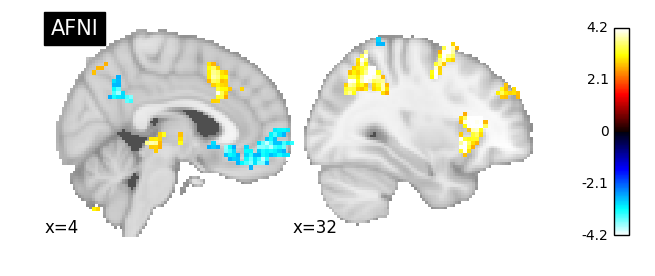

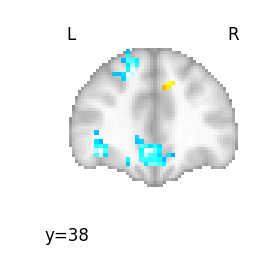

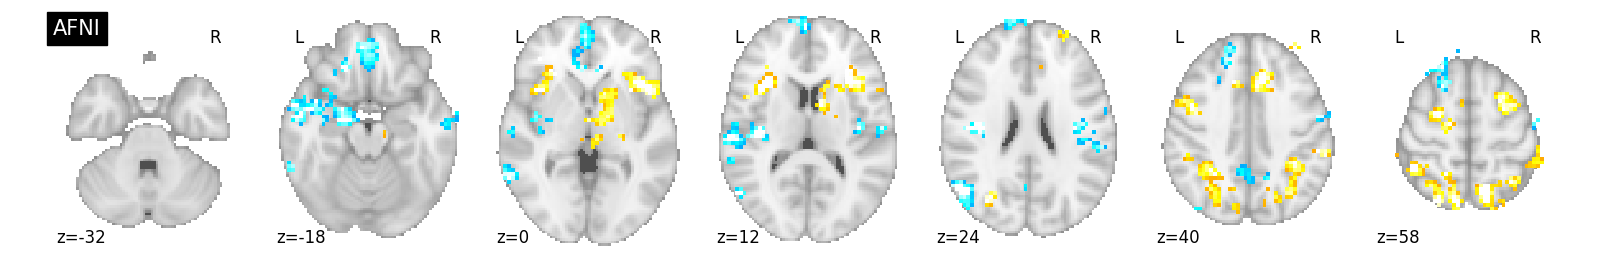

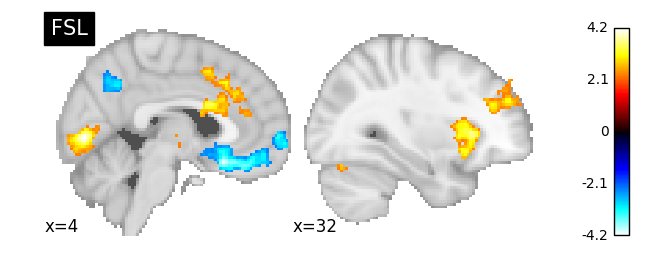

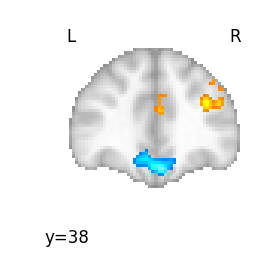

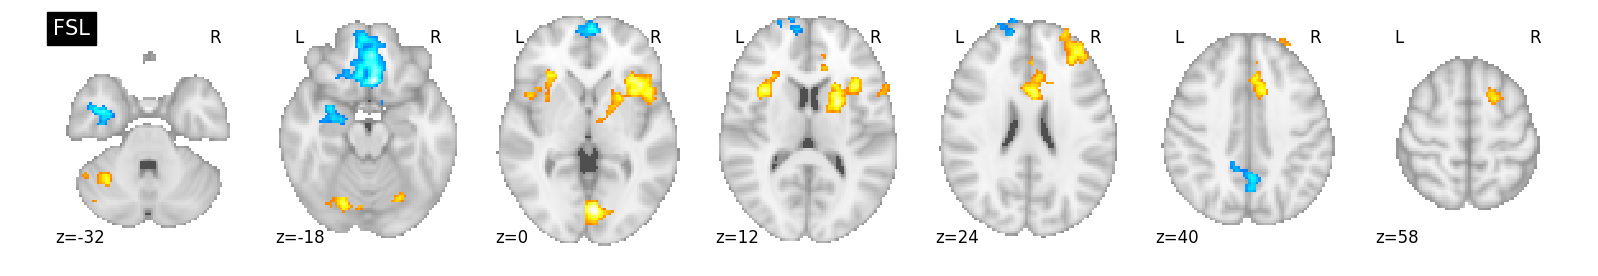

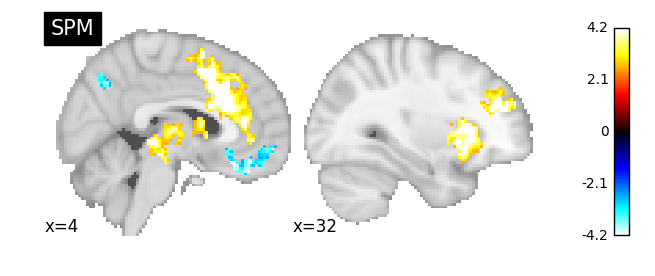

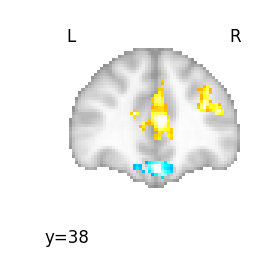

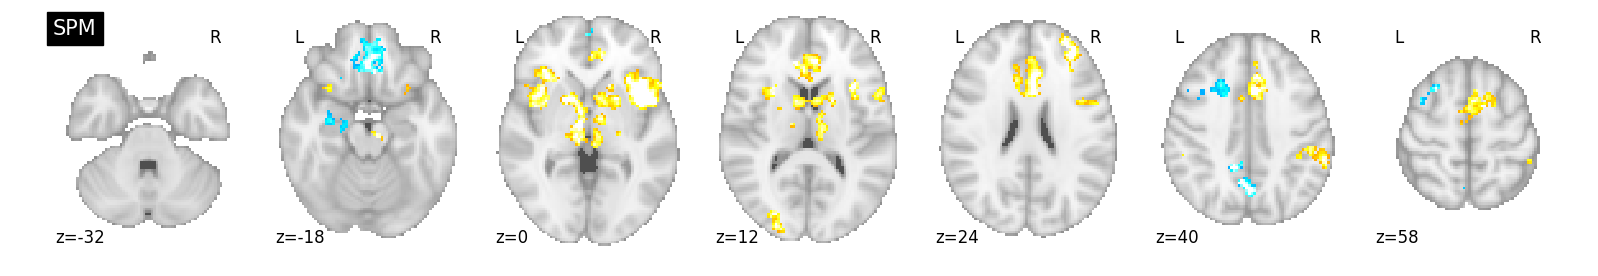

In [5]:
from scripts.lib import plot_excursion_sets
reload(plot_excursion_sets)
plot_excursion_sets.plot_excursion_sets(exc_sets)

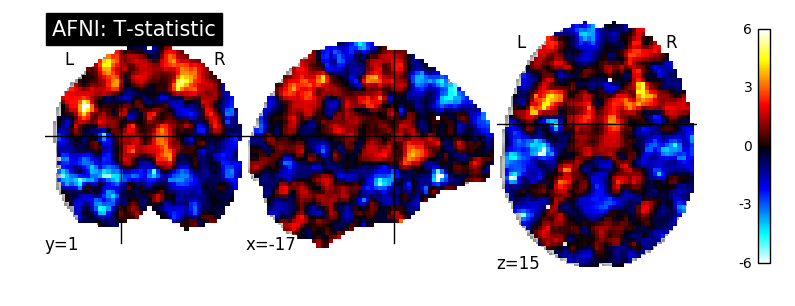

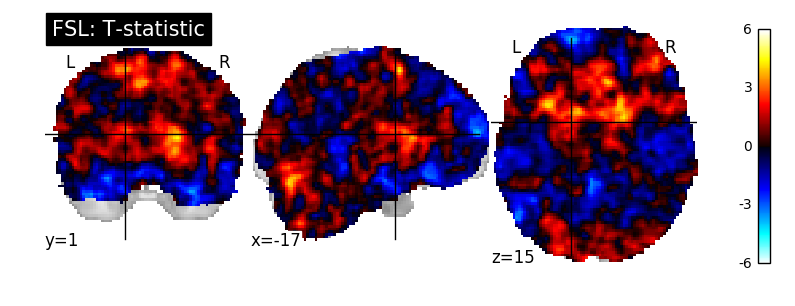

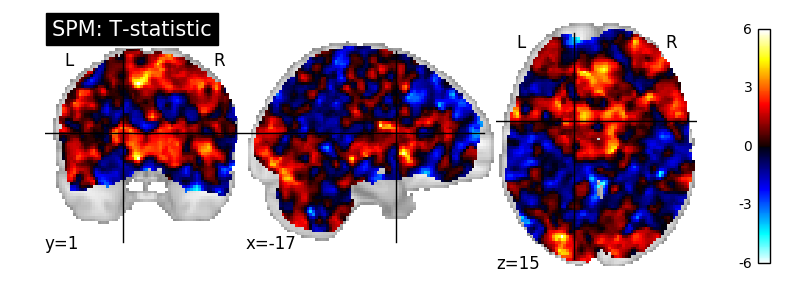

In [6]:
from scripts.lib import plot_stat_images
reload(plot_stat_images)
plot_stat_images.plot_stat_images(afni_stat_file, spm_stat_file, [-17, 1, 15], fsl_stat_file)

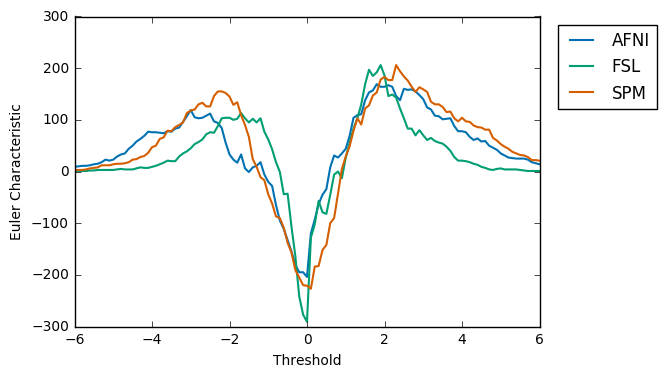

In [7]:
from scripts.lib import euler_characteristics
reload(euler_characteristics)
euler_characteristics.euler_characteristics(euler_chars)

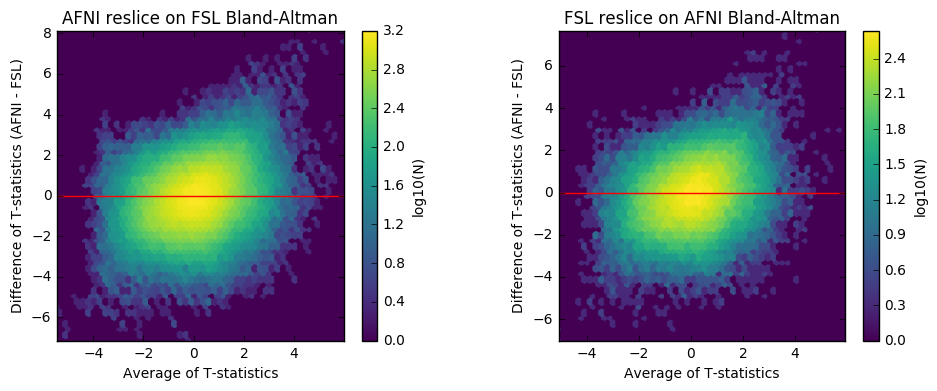

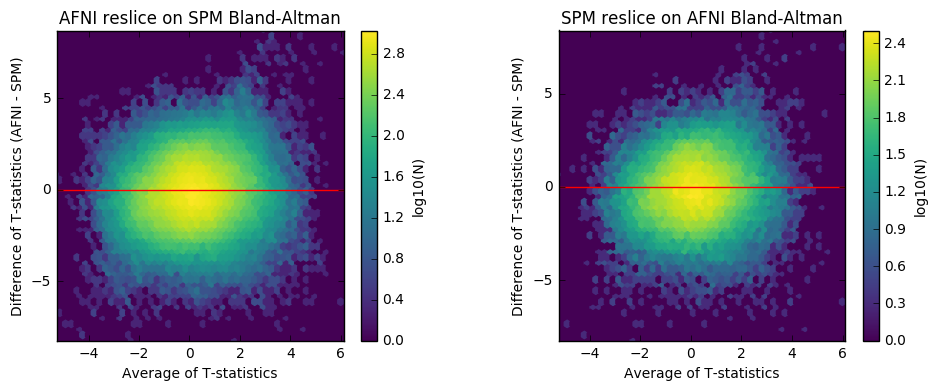

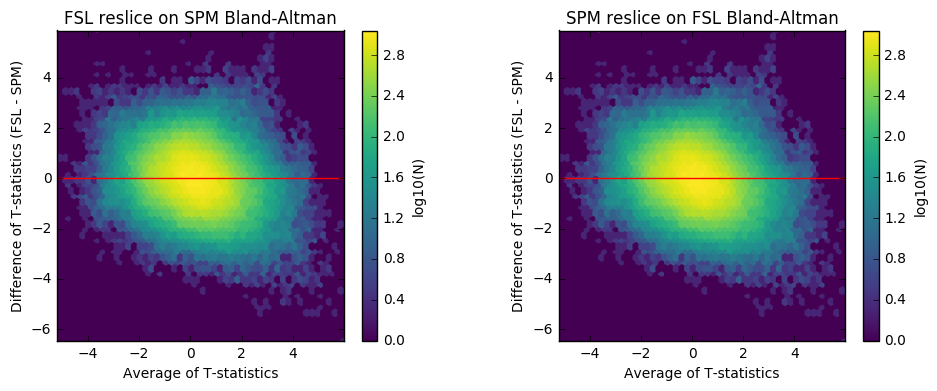

In [17]:
from scripts.lib import bland_altman
reload(bland_altman)
bland_altman.bland_altman(afni_stat_file, spm_stat_file,
             afni_reslice_spm, afni_spm_reslice,
             fsl_stat_file, fsl_reslice_spm,
             afni_fsl_reslice, afni_reslice_fsl, fsl_spm_reslice)

In [15]:
from scripts.lib import dice
reload(dice)
dice.dice(afni_exc_set_file, afni_exc_set_file_neg, 
         spm_exc_set_file, spm_exc_set_file_neg,
         afni_reslice_spm_pos_exc, afni_reslice_spm_neg_exc, 
         afni_spm_reslice_pos_exc, afni_spm_reslice_neg_exc,
         afni_reslice_fsl_pos_exc, afni_reslice_fsl_neg_exc, 
         afni_fsl_reslice_pos_exc, afni_fsl_reslice_neg_exc,
         fsl_exc_set_file, fsl_exc_set_file_neg, 
         fsl_reslice_spm_pos_exc, fsl_reslice_spm_neg_exc,
         fsl_spm_reslice_pos_exc, fsl_spm_reslice_neg_exc)

AFNI/FSL positive activation dice coefficient = 0.195961995249
FSL/AFNI positive activation dice coefficient = 0.183079677708

AFNI/FSL negative activation dice coefficient = 0.198402613905
FSL/AFNI negative activation dice coefficient = 0.195269860522

AFNI/SPM positive activation dice coefficient = 0.226210857679
SPM/AFNI positive activation dice coefficient = 0.209953051643

AFNI/SPM negative activation dice coefficient = 0.128783382789
SPM/AFNI negative activation dice coefficient = 0.122516556291

FSL/SPM positive activation dice coefficient = 0.365437208959
SPM/FSL positive activation dice coefficient = 0.365437208959

FSL/SPM negative activation dice coefficient = 0.35358649789
SPM/FSL negative activation dice coefficient = 0.35358649789

